In [1]:
%load_ext autoreload
%autoreload 2
from imports.networks import *
from imports.data import *
from imports.params import p
import matplotlib.pyplot as plt

In [28]:
p["soapfile"] = "halo_properties_0078.hdf5"
p["simsize"] = "L2800N5040"
p["snapshot"] = "flamingo_0078/flamingo_0078.hdf5"
p["cosmology"] = "HYDRO_FIDUCIAL"
data = Data(p)

total nr halos in selection:  10157002
nr inside mass selection:  23521295
nr with nonzero luminosity:  10994287


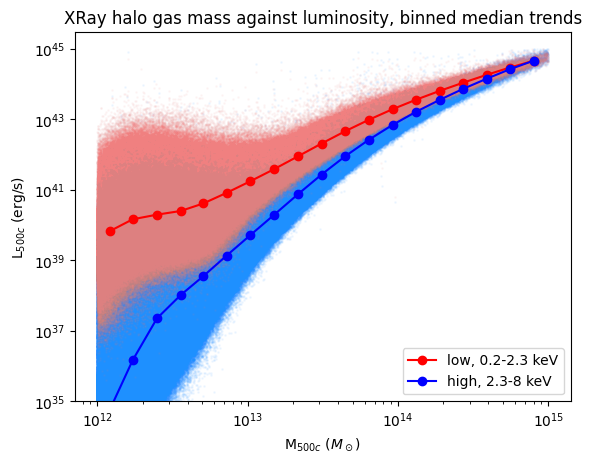

In [29]:
### get median binned mass per luminosity 
mass = data.soap_file[f"{p['selection_type']}/TotalMass"][:]

luminosity = data.soap_file[f"{p['selection_type']}/XRayLuminosityWithoutRecentAGNHeating"][:]
luminosity_selection_low = luminosity[:,0] < 1e45
luminosity_selection_high = luminosity[:,1] < 1e45
mass_selection = np.logical_and(mass > 1e12, mass < 1e15)
nonzero = (np.sum(luminosity[:,:2] == 0, axis=1) == 0)

selection = mass_selection*nonzero*luminosity_selection_low*luminosity_selection_high

mass = mass[selection]
luminosity = luminosity[selection]
print("total nr halos in selection: ", len(mass))
print("nr inside mass selection: ", np.sum(mass_selection))
print("nr with nonzero luminosity: ", np.sum(nonzero))


plt.scatter(mass, luminosity[:, 1], s=1, c="dodgerblue", alpha=0.05)
plt.scatter(mass, luminosity[:, 0], s=1, c="lightcoral", alpha=0.05)


bins = np.logspace(12, 15, 20)

luminosities_low = []
masses_low = []
luminosities_high = []
masses_high = []
for i in range(len(bins)-1):
    indices = np.logical_and(mass > bins[i], mass < bins[i+1])

    luminosities_low.append(np.median(luminosity[indices,0]))
    masses_low.append(np.median(mass[indices]))
    
    luminosities_high.append(np.median(luminosity[indices,1]))
    masses_high.append(np.median(mass[indices]))

# plt.figure(figsize=(10, 10))
plt.plot(masses_low, luminosities_low, c="red", marker="o", label="low, 0.2-2.3 keV")
plt.plot(masses_high, luminosities_high, c="blue", marker="o", label="high, 2.3-8 keV")
plt.ylim(1e35, 3e45)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("M$_{500c}$ $(M_\odot)$")
plt.ylabel("L$_{500c}$ (erg/s)")
plt.title("XRay halo gas mass against luminosity, binned median trends")
plt.legend()
plt.show()

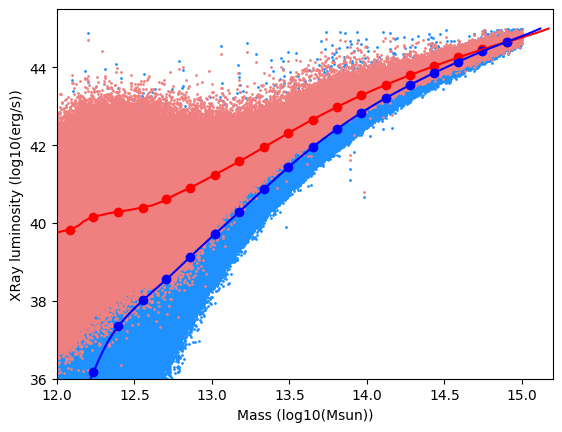

In [30]:
### get splines through these binned medians
from scipy.interpolate import CubicSpline
spl_low = CubicSpline(np.log10(luminosities_low), np.log10(masses_low), bc_type=((1, 0.79), (2, 0.0)))
spl_high = CubicSpline(np.log10(luminosities_high), np.log10(masses_high), bc_type="natural")

x = np.linspace(35, 45, 100)
plt.plot(spl_low(x), x, c="red")
plt.plot(spl_high(x), x, c="blue")
plt.scatter(np.log10(mass), np.log10(luminosity[:, 1]), s=1, c="dodgerblue", alpha=1)
plt.scatter(np.log10(mass), np.log10(luminosity[:, 0]), s=1, c="lightcoral", alpha=1)
plt.scatter(np.log10(masses_low), np.log10(luminosities_low), c="red", label="low, 0.2-2.3 keV")
plt.scatter(np.log10(masses_high), np.log10(luminosities_high), c="blue", label="high, 2.3-8 keV")
plt.xlim(12, 15.2)
plt.ylim(36, 45.5)
plt.xlabel("Mass (log10(Msun))")
plt.ylabel("XRay luminosity (log10(erg/s))")
plt.show()

In [31]:
### save splines
filename = p_to_filename(p)
np.save(p['model_path'] + filename + "_spline_fit_low", spl_low, allow_pickle=True)
np.save(p['model_path'] + filename + "_spline_fit_high", spl_high, allow_pickle=True)


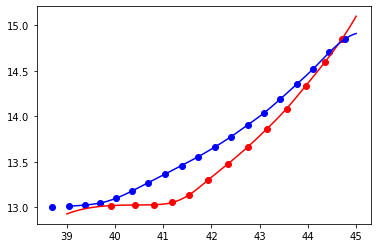

In [21]:
x = np.linspace(39, 45, 100)

spl_low = np.load(f"{p['base_model_path']}/spline_fit_low_M13-15_L45.npy", allow_pickle=True)[()]
spl_high = np.load(f"{p['base_model_path']}/spline_fit_high_M13-15_L45.npy", allow_pickle=True)[()]

plt.plot(x, spl_low(x), c="red")
plt.plot(x, spl_high(x), c="blue")
plt.scatter(np.log10(luminosities_low), np.log10(masses_low), c="red")
plt.scatter(np.log10(luminosities_high), np.log10(masses_high), c="blue")
plt.show()



In [345]:
# def predict_mass(l, band="low"):
#     poly = np.poly1d(np.load(f"/home/tol/Documents/Thesis/models/linear_fit_{band}_6.npy"))
#     return 10**poly(np.log10(l))

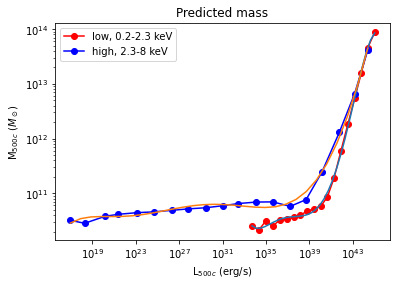

In [353]:
plt.plot(luminosities_low, gasmasses_low, c="red", marker="o", label="low, 0.2-2.3 keV")
plt.plot(luminosities_high, gasmasses_high, c="blue", marker="o", label="high, 2.3-8 keV")

testluminosities = np.logspace(np.log10(luminosities_low[0]), np.log10(luminosities_low[-1]), 30)
plt.plot(testluminosities, predict_mass(testluminosities, band="low"))

testluminosities = np.logspace(np.log10(luminosities_high[0]), np.log10(luminosities_high[-1]), 30)
plt.plot(testluminosities, predict_mass(testluminosities, band="high"))


plt.xscale("log")
plt.yscale("log")
plt.ylabel("M$_{500c}$ $(M_\odot)$")
plt.xlabel("L$_{500c}$ (erg/s)")
plt.title("Predicted mass")
plt.legend()
plt.show()